In [1]:
import numpy as np
import pandas as pd

import os
import sys
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
TEMP_DIR = '../'
BASE_DIR = '../'
TEST_DIR = BASE_DIR+'/test-images'
with open(BASE_DIR+"classes-segmentation.txt") as f:
    CLASSES = [c.strip() for c in f.readlines()]
CLASSES = ["__background__"] + CLASSES
NUM_CLASS = len(CLASSES)
CLOP_SIZE = 480
BASE_SIZE = 520
NUM_CROP = 1

In [3]:
import torch
import torchvision
import PIL

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=NUM_CLASS, pretrained_backbone=True)
model.load_state_dict(torch.load("final_model"))
model.eval()
model.cuda()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# inference

In [6]:
IMAGE_DIR = "../../input/test/"

In [8]:
empty_submission_df = pd.read_csv("../../input/sample_empty_submission.csv")
empty_submission_df.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,-1,-1,NaN
1,52a76f3fe21185bf,-1,-1,NaN
2,65e9da7c04c8e4cd,-1,-1,NaN
3,6d10fa21d93bd6cc,-1,-1,NaN
4,0841dee573a875ca,-1,-1,NaN


In [9]:
sample_image = "../../input/test/52c49cd9fee4319b.jpg"
image = PIL.Image.open(sample_image)
image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
results = model([image_tensor])
del image_tensor

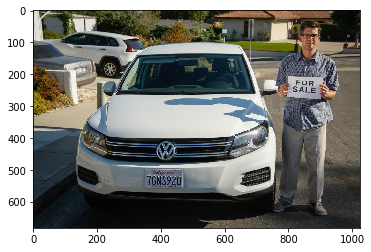

In [10]:
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

In [14]:
results

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]

In [11]:
# Visualize results
r = results[0]
print(r.keys())
print(r["labels"])
print(r["scores"])

#visualize.display_instances(image, r['boxes'], r['masks'], r['labels'], class_names, r['scores'])

dict_keys(['boxes', 'labels', 'scores'])
tensor([], device='cuda:0', dtype=torch.int64)
tensor([], device='cuda:0', grad_fn=<IndexBackward>)


In [18]:
r['boxes']

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>)

In [19]:
r['masks'][:,0,341,512]

KeyError: 'masks'

See:
https://pytorch.org/docs/stable/torchvision/models.html

In [13]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
coco_names = COCO_INSTANCE_CATEGORY_NAMES

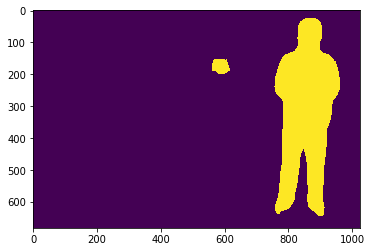

In [14]:
mask = np.zeros((r['masks'].shape[2],r['masks'].shape[3]))
for i,l in enumerate(r["labels"].detach().cpu().numpy()):
    if coco_names[l] == "person":
        mask += r['masks'].detach().cpu().numpy()[i,0,:,:]
plt.imshow(mask > 0.5)

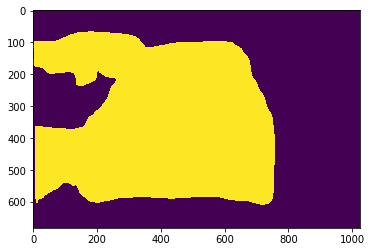

In [15]:
mask = np.zeros((r['masks'].shape[2],r['masks'].shape[3]))
for i,l in enumerate(r["labels"].detach().cpu().numpy()):
    if coco_names[l] == "car":
        mask += r['masks'].detach().cpu().numpy()[i,0,:,:]
plt.imshow(mask > 0.5)

See:  
https://www.kaggle.com/c/open-images-2019-instance-segmentation/overview/evaluation

In [16]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [17]:
ImageID_list = []
ImageWidth_list = []
ImageHeight_list = []
PredictionString_list = []

for num, row in tqdm(empty_submission_df.iterrows(), total=len(empty_submission_df)):
    filename = row["ImageID"] + ".jpg"
    image = PIL.Image.open(os.path.join(IMAGE_DIR, filename))
    image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()

    results = model([image_tensor])
    r = results[0]
    
    height = image.height
    width  = image.width
        
    PredictionString = ""
    
    r_labels = r["labels"].detach().cpu().numpy()
    r_scores = r["scores"].detach().cpu().numpy()
    r_masks = r["masks"].detach().cpu().numpy()

    for i, (class_id, confidence) in enumerate(zip(r_labels, r_scores)):
        encoded_mask = encode_binary_mask(r_masks[i,:,:] > 0.5)
        encoded_label = CLASSES[class_id]

        PredictionString += encoded_label 
        PredictionString += " "
        PredictionString += str(confidence)
        PredictionString += " "
        PredictionString += encoded_mask.decode()
        PredictionString += " "
        
    ImageID_list.append(row["ImageID"])
    ImageWidth_list.append(width)
    ImageHeight_list.append(height)
    PredictionString_list.append(PredictionString)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version


In [18]:
results=pd.DataFrame({"ImageID":ImageID_list,
                      "ImageWidth":ImageWidth_list,
                      "ImageHeight":ImageHeight_list,
                      "PredictionString":PredictionString_list
                     })

In [19]:
results.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/01k6s3 0.39089352 eNp1U8luwyAQ/SUwtkLqS6WiO...
1,52a76f3fe21185bf,1024,683,/m/0bt9lr 0.78929484 eNqVkcEOwjAIQH8J2mniyYNXC...
2,65e9da7c04c8e4cd,1024,682,
3,6d10fa21d93bd6cc,1024,682,/m/01g317 0.99972624 eNqdU21PgzAQ/kvQUq6bWaYxQ...
4,0841dee573a875ca,1024,683,/m/06_fw 0.7704366 eNpVUmt3ojAU/Es3gq6rW+vj2Fb...


In [20]:
results.shape

(99999, 4)

In [21]:
results.to_csv("submission001.csv", index=False)